In [2]:
import numpy as np
import pandas as pd
import time
from collections import OrderedDict
from sklearn import preprocessing
from matplotlib import pyplot as plt
import annoy

# Data Preparation

In [3]:
%%time
#200000 compounds with 469 features
all_features = pd.read_csv("c2vpoint2m.txt.gz", sep="\t", header=None)

CPU times: user 24.2 s, sys: 3.92 s, total: 28.1 s
Wall time: 29.1 s


In [4]:
#make the compound names the index
all_features.set_index(0, inplace=True)

In [5]:
%%time
#725634 compounds with target and activity
cgan = pd.read_csv("activities.txt.gz", sep="\t")

CPU times: user 27.8 s, sys: 8.45 s, total: 36.3 s
Wall time: 37.5 s


In [6]:
#we are only interested in the compounds whose target is EGFR
egfr_activity = cgan[cgan['target'] == 'EGFR'].set_index('compound')

In [7]:
#separate into two dataframes, one with active compounds
egfr_active = egfr_activity[egfr_activity['activity'] >= 6]
egfr_active_compounds = egfr_active.index.values

In [8]:
#and one with inactive ones
egfr_inactive = egfr_activity[egfr_activity['activity']  < 6]
egfr_inactive_compounds = egfr_inactive.index.values

In [9]:
#5275 compounds with EGFR target and 469 features
egfr_features = pd.read_csv("egfr.c2v.txt", sep="\t", header=None).set_index(0)

In [10]:
#isolate the names for easier access
egfr_compounds = egfr_features.index.values

In [11]:
#make dataframes with features for the active and inactive compounds
egfr_active_features = egfr_features.loc[egfr_active_compounds]
egfr_inactive_features = egfr_features.loc[egfr_inactive_compounds]

In [12]:
#scale the data so that each feature is normalized and can be compared to other features
min_max_scaler = preprocessing.MinMaxScaler() #fits data between 0 and 1

In [13]:
#normalize the active compounds
egfr_active_features_norm = pd.DataFrame(min_max_scaler.fit_transform(egfr_active_features), 
                                         index=egfr_active_features.index)

In [14]:
#normalize the inactive compounds
egfr_inactive_features_norm = pd.DataFrame(min_max_scaler.fit_transform(egfr_inactive_features), 
                                           index=egfr_inactive_features.index)

In [15]:
#remove duplicates from all_features - can also use DataFrame.drop_duplicates()
all_features_cleaned = all_features.loc[list(set(all_features.index.values) - set(egfr_compounds))]

In [16]:
#normalize the database
all_features_cleaned_norm = pd.DataFrame(min_max_scaler.fit_transform(all_features_cleaned), index=all_features_cleaned.index)

# Logic Creation

In [17]:
def dataprep(active, rest, size, seed):
    #create the query from a random sample of the data
    size = int(active.shape[0] * size + .5)
    query = active.sample(n=size, random_state=seed)
    
    #remove the query, then concatenate the remaining data for training
    sub = list(set(active.index.values) - set(query.index.values))
    active_minus_query = active.loc[sub]
    database = pd.concat([active_minus_query] + rest)
    
    return database, query

In [18]:
def buildAnnoyModel(database, n_neighbors, metric, n_trees):
    #create model - first argument is the length of the vectors
    index = annoy.AnnoyIndex(database.shape[1], metric=metric)
    
    #add training data
    start = time.time()
    
    #note that this is much slower than the other models because the data must be
    #added row-by-row instead of the entire database at once
    for i in range(database.shape[0]):
        index.add_item(i, database.loc[database.index.values[i]])
    
    #build trees
    index.build(n_trees)
    end = time.time()
    
    build_time = end - start
    
    return index, build_time

In [23]:
def runAnnoyQuery(model, query, n_neighbors, database, active):
    indices = []
    
    #run query
    start = time.time()
    for j in range(query.shape[0]):
        i = model.get_nns_by_vector(query.loc[query.index.values[j]], n_neighbors)
        indices.append(i)
    end = time.time()
    
    query_time  = end - start
    
    #assess the quality of the results - how many of the neighbors are in the success dataframe
    sum = 0
    for i in indices:
        count = 0
        for j in i:
            if database.index.values[j] in active.index.values:
                count += 1
        sum += count / float(n_neighbors)
    average = sum / query.shape[0]
    
    return average, query_time

In [24]:
#active: the dataframe containing the compounds that you want to receive back: in this case, egfr_active
#rest: a list of other dataframes that will complete the database
#size: proportion of active that is sampled for the query
#n_neighbors: the number of neighbors found for each compound in the query
#metric: the distance metric used for the model
#n_trees: the number of trees built in the model
#seed: the random seed used for sampling
def annoyNN(active, rest, size, n_neighbors, metric, n_trees, seed):
    #prepare the data
    database, query = dataprep(active, rest, size, seed)
    
    #build the model
    model, build_time = buildAnnoyModel(database, n_neighbors, metric, n_trees)
    
    #run the query
    average, query_time = runAnnoyQuery(model, query, n_neighbors, database, active)
 
    #return the results in a table
    d = OrderedDict({'algorithm/index':['Annoy' + ' (' + str(n_trees) + ' trees)'], 'metric':[metric], 
                     'n_neighbors':[n_neighbors], 'query size':[size], 'build time (s)':[build_time], 
                     'query time (s)':[query_time], 'quality':[average], 'seed':[seed]})
    
    return pd.DataFrame(data=d)

# Tests

In [25]:
annoy_results = pd.DataFrame()

In [26]:
temp = []
for metric in ['angular', 'euclidean', 'manhattan', 'hamming']:
    for n_trees in [5, 10, 20]:
        temp.append(annoyNN(active=egfr_active_features_norm, rest=[all_features_cleaned_norm, egfr_inactive_features_norm], 
                            size=0.2, n_neighbors=100, metric=metric, n_trees=n_trees, seed=0))
annoy_results = pd.concat(temp)
annoy_results

,algorithm/index,metric,n_neighbors,query size,build time (s),query time (s),quality,seed
0,Annoy (5 trees),angular,100,0.2,723.482300,2.058579,0.998246,0
0,Annoy (10 trees),angular,100,0.2,730.550405,2.304622,0.998153,0
0,Annoy (20 trees),angular,100,0.2,732.995871,2.252247,0.998153,0
0,Annoy (5 trees),euclidean,100,0.2,723.889000,1.994144,0.998190,0
0,Annoy (10 trees),euclidean,100,0.2,724.186985,2.036737,0.998190,0
0,Annoy (20 trees),euclidean,100,0.2,725.322108,2.462112,0.998190,0
0,Annoy (5 trees),manhattan,100,0.2,721.212340,2.006412,0.998153,0
0,Annoy (10 trees),manhattan,100,0.2,723.780788,2.047477,0.998153,0
0,Annoy (20 trees),manhattan,100,0.2,729.862504,2.130785,0.998190,0
0,Annoy (5 trees),hamming,100,0.2,794.426924,7.118552,0.997985,0


In [63]:
annoy_results[['algorithm/index', 'metric', 'build time (s)', 'query time (s)']].groupby(
    ['metric']).describe()

build time (s)                                                 \
                   count        mean        std         min         25%   
metric                                                                    
angular              3.0  729.009525   4.940419  723.482300  727.016352   
euclidean            3.0  724.466031   0.756207  723.889000  724.037992   
hamming              3.0  766.816377  26.942598  740.595513  753.011104   
manhattan            3.0  724.951877   4.442400  721.212340  722.496564   

                                              query time (s)            \
                  50%         75%         max          count      mean   
metric                                                                   
angular    730.550405  731.773138  732.995871            3.0  2.205150   
euclidean  724.186985  724.754546  725.322108            3.0  2.164331   
hamming    765.426694  779.926809  794.426924            3.0  3.736392   
manhattan  723.780788  726.821646  729.862504            3.0  2.061558   

                                                                       
                std       min       25%       50%       75%       max  
metric                                                                 
angular    0.129607  2.058579  2.155413  2.252247  2.278435  2.304622  
euclidean  0.258764  1.994144  2.015441  2.036737  2.249425  2.462112  
hamming    2.929062  2.033044  2.045312  2.057580  4.588066  7.118552  
manhattan  0.063371  2.006412  2.026944  2.047477  2.089131  2.130785

# Graphs


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
annoy_results = pd.read_csv("annoy_results.txt")

In [ ]:
annoy_results = annoy_results[['algorithm/index', 'metric', 'n_neighbors', 
                                  'query size', 'build time (s)', 'query time (s)', 'quality', 'seed']]

In [ ]:
a = annoy_results

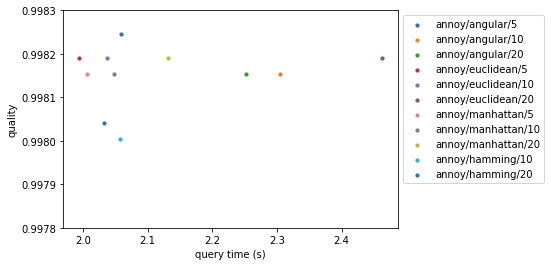

In [39]:
plt.figure()
for i in range(12):
    if i != 9:
        plt.scatter(a[i:i+1]['query time (s)'], a[i:i+1]['quality'], s=10)
plt.ylim(0.9978, 0.9983)
plt.xlabel('query time (s)')
plt.ylabel('quality')
plt.legend(['annoy/angular/5', 'annoy/angular/10', 'annoy/angular/20', 
            'annoy/euclidean/5', 'annoy/euclidean/10', 'annoy/euclidean/20', 
            'annoy/manhattan/5', 'annoy/manhattan/10', 'annoy/manhattan/20', 
            #'annoy/hamming/5', 
            'annoy/hamming/10', 'annoy/hamming/20'], bbox_to_anchor=(1, 1))
plt.show()

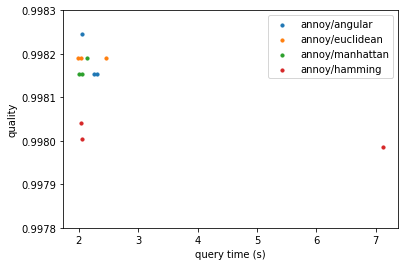

In [41]:
plt.figure()
for i in range(4):
        plt.scatter(a[i*3:i*3+3]['query time (s)'], a[i*3:i*3+3]['quality'], s=10)
plt.ylim(0.9978, 0.9983)
plt.xlabel('query time (s)')
plt.ylabel('quality')
plt.legend(['annoy/angular', 
            'annoy/euclidean', 
            'annoy/manhattan', 
            'annoy/hamming'], bbox_to_anchor=(1, 1))
plt.show()

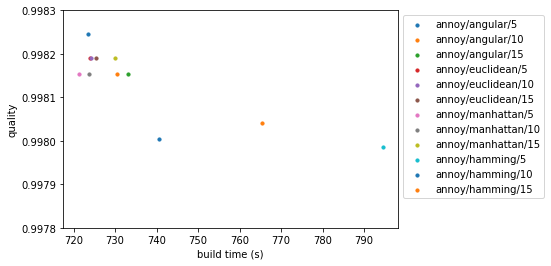

In [44]:
plt.figure()
for i in range(12):
    plt.scatter(a[i:i+1]['build time (s)'], a[i:i+1]['quality'], s=10)
plt.ylim(0.9978, 0.9983)
plt.xlabel('build time (s)')
plt.ylabel('quality')
plt.legend(['annoy/angular/5', 'annoy/angular/10', 'annoy/angular/15', 
            'annoy/euclidean/5', 'annoy/euclidean/10', 'annoy/euclidean/15', 
            'annoy/manhattan/5', 'annoy/manhattan/10', 'annoy/manhattan/15', 
            'annoy/hamming/5', 'annoy/hamming/10', 'annoy/hamming/15'], bbox_to_anchor=(1, 1))
plt.show()

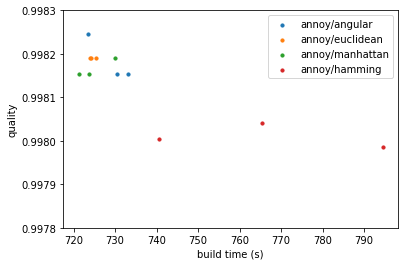

In [46]:
plt.figure()
for i in range(4):
        plt.scatter(a[i*3:i*3+3]['build time (s)'], a[i*3:i*3+3]['quality'], s=10)
plt.ylim(0.9978, 0.9983)
plt.xlabel('build time (s)')
plt.ylabel('quality')
plt.legend(['annoy/angular', 
            'annoy/euclidean', 
            'annoy/manhattan', 
            'annoy/hamming'], bbox_to_anchor=(1, 1))
plt.show()

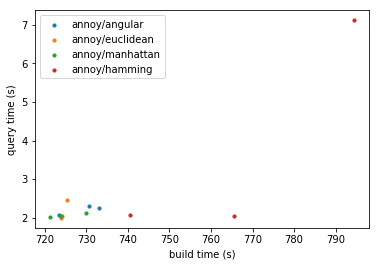

In [50]:
#graph of build time vs query time for each of the algorithm/metric combinations
#lower left is better
plt.figure()
for i in range(4):
        plt.scatter(a[i*3:i*3+3]['build time (s)'], a[i*3:i*3+3]['query time (s)'], s=10)

plt.xlabel('build time (s)')
plt.ylabel('query time (s)')
plt.legend(['annoy/angular', 
            'annoy/euclidean', 
            'annoy/manhattan', 
            'annoy/hamming'])

plt.show()